In [30]:
%matplotlib inline

import numpy as np
# import imageio
import matplotlib.pyplot as plt
# import pandas as pd
#import sklearn.datasets
import cv2 as cv
# import glob

# import os

# Cargar arreglo NumPy desde un archivo
from numpy import loadtxt
# Cargar Arreglo
punto_inicio = loadtxt('punto_inicio.csv', delimiter=',',dtype=np.int)
# Imprimir el arreglo
print(punto_inicio)
punto_final = loadtxt('punto_final.csv', delimiter=',',dtype=np.int)
# Imprimir el arreglo
print(punto_final)
obstaculos = loadtxt('obstaculos.csv', delimiter=',',dtype=np.int)
# Imprimir el arreglo
print(obstaculos)

[137 140]
[485 256]
[[366 240  84]
 [293 113  20]
 [213 166  20]
 [193 312  20]
 [236 372  20]
 [551 256  21]]


In [52]:
class pathing:
    def __init__(self, inicio, fin, obstaculos):
        self.inicio = inicio
        self.fin = fin
        self.obstaculos = obstaculos*[1,1,1]
        self.path=np.array([inicio])
        self.i=True
        self.escalaRadio=1
        #memorias
        self.Minicio=self.inicio
        self.Mfin=self.fin
        self.Mobstaculos=self.obstaculos
        #self.M2obstaculos=self.obstaculos
        self.Mpath=self.path
        self.Mi=self.i
        
        
        
    #metodos
        
    def generate(self):
        self.inicio=self.Minicio
        self.fin=self.Mfin
        self.obstaculos=self.Mobstaculos*[1,1,self.escalaRadio]
        self.path=self.Mpath
        self.i=self.Mi
        
        while self.i == True:
            
#             print(self.inicio[0]==punto_final[0],self.inicio[1]==punto_final[1])
#             print(self.fin)
#             print(self.path,self.i)
            maskObs=self.maskObstaculos(self.obstaculos)
#             print(self.obstaculos*[1,1,1])
#             print(self.obstaculos*[1,1,1.5])
#             plt.figure(figsize=(12,12))
#             plt.imshow(maskObs, cmap='viridis')
        
            maskInicioFin= self.maskLineaInicioFin(self.inicio , self.fin)
        
            inter , _ =self.maskIntersecciones(maskInicioFin,maskObs)
                   
            primer_obstaculo , numero_del_obstaculo=self.maskObstaculoMasCercano(inter,self.inicio,self.obstaculos)
                     
            linea_I_O = self.maskLineaInicioObstaculo(self.inicio,self.obstaculos,numero_del_obstaculo)
                   
            perpendicular=self.maskPerpendicular(self.inicio,self.obstaculos,numero_del_obstaculo)
                      
            inter_primer_obs , __ =self.maskIntersecciones(perpendicular,primer_obstaculo)
            #plt.figure(figsize=(12,12))
            #plt.imshow(inter_primer_obs, cmap='viridis')
        
            maskPuntos,puntos_x,puntos_y=self.puntosExtremos(inter_primer_obs,self.obstaculos,numero_del_obstaculo)
        
            punto=self.puntoCercanoFinal(self.fin,puntos_x,puntos_y) 
        
            self.iterarPuntos(punto,self.fin,self.obstaculos,numero_del_obstaculo)
            
        ##comprobando si el path choca obstaculos
        
        maskMObs=self.maskObstaculos(self.Mobstaculos)
        
        maskPath=self.dibujandoPath(self.path)
        
        
        maskChoques,choques=self.maskIntersecciones(maskPath,maskMObs)
        
        Choques1=self.dibujandoPath(self.path,maskMObs)
        
        plt.figure(figsize=(12,12))
        plt.imshow(maskChoques,cmap="viridis")
        
        plt.figure(figsize=(12,12))
        plt.imshow(choques,cmap="viridis")
        
        plt.figure(figsize=(12,12))
        plt.imshow(Choques1,cmap="viridis")
        
        if maskChoques.any()==False:
            return self.path
        else:
            self.escalaRadio += 0.1
            return self.generate()
            
        
        print(self.path)
        return self.path
#         print(self.inicio,self.fin)
#         print(self.obstaculos)
#         #mask2=linea_I_O+perpendicular
#         plt.figure(figsize=(12,12))
#         plt.imshow(maskPuntos, cmap='viridis')
# #         plt.figure(figsize=(12,12))
# #         plt.imshow(mask2, cmap='viridis')
#         print('via points')
#         print(punto==self.fin)
        
    def seg_color(self,src,bajos, altos):
        mask = cv.inRange(src, bajos, altos)
        return mask

    def dibujarObs(self,mask,x,y,radio):
        radio=round(radio)
        x=int(x)
        y=int(y)
        #mask=np.zeros((mask.shape[0],mask.shape[1]),dtype=np.uint8)
        #Dibujando un círculos
        cv.circle(mask,(x,y),radio,(150),-1)
        return mask
        #plt.figure(figsize=(12,12))
        #plt.imshow(mask, cmap='viridis')
    def maskObstaculos(self, obstaculos):
        mask = np.zeros((480,640),dtype=np.uint8)
        for i in obstaculos:
            mask = self.dibujarObs(mask,i[0],i[1],i[2])
            
        return mask
    
    def maskLineaInicioFin(self, punto_inicio, punto_final):
        mask = np.zeros((480,640),dtype=np.uint8)
        cv.line(mask,(punto_inicio[0],punto_inicio[1]),(punto_final[0],punto_final[1]),(255),2)
        return mask
    
    def maskIntersecciones(self, mask1, mask):
        if mask1.size == 0:
            return np.array([]),np.array([])
        diferencias=cv.subtract(mask1,mask)
        inters = np.array([105], dtype=np.uint8)
        mask = self.seg_color(diferencias, inters, inters)
        return mask,diferencias
    
    def maskObstaculoMasCercano(self, intersecciones, punto_inicio,obstaculos):
        
        ##puntos de las intesecciones
        puntos_y, puntos_x=np.where(intersecciones)
        ##punto de interseccion mas cercano al inicio
        distancia = np.sqrt((puntos_x-punto_inicio[0])**2 + (puntos_y-punto_inicio[1])**2)#distancia euclidiana
        if not distancia.any():
            #print("List is empty aja")
            #print(puntos_y,puntos_x)
            self.i=False
            return np.array([]),np.array([])
        pos=np.where(distancia == min(distancia))
        
        #print(pos)
        ##punto mas cercano
        #maskInicio=dibujarObs(maskInicio,int(puntos_x[pos]),int(puntos_y[pos]),5)
        
        ##obstaculo al que le pertenece ese punto
        distanciaObs = np.sqrt((obstaculos[:,0]-puntos_x[pos])**2+(obstaculos[:,1]-puntos_y[pos])**2)
        posObs=np.where(distanciaObs == min(distanciaObs))#cual es el obstaculo
        
        #mascara del obstaculo correspondiente
        mask = np.zeros((480,640),dtype=np.uint8)
        obstaculo = obstaculos[posObs].flatten()
        mask= self.dibujarObs(mask,obstaculo[0],obstaculo[1],obstaculo[2])
                
        return mask, posObs[0]
    
    def maskLineaInicioObstaculo(self,punto_inicio,obstaculos,posObs):
        
        if posObs.size == 0:
            return np.array([])
        mask = np.zeros((480,640),dtype=np.uint8)
        cv.line(mask,(punto_inicio[0],punto_inicio[1]),(int(obstaculos[posObs,0]),int(obstaculos[posObs,1])),(255),2)
        return mask
    
    def vector_p(self,punto_inicial_x,punto_inicial_y,punto_final_x,punto_final_y):
        #establecer vector con los puntos
        vector_x=punto_inicial_x-punto_final_x
        vector_y=punto_inicial_y-punto_final_y
        vector=np.array([vector_x,vector_y])
        return vector
    
    def perpendicular_90(self,vector,escala=1):
        theta= np.deg2rad(90)
        matriz=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])*escala
        perpendicular=matriz.dot(vector)
        #perpendicular.dtype=int
        return perpendicular.astype(int)
    
    def perpendicular_270(self,vector,escala=1):
        theta= np.deg2rad(-90)
        matriz=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])*escala
        perpendicular=matriz.dot(vector)
        #perpendicular.dtype=int
        return perpendicular.astype(int)
    
    def dibujar_perpendiculares(self,centroide_obstaculo,perpendicular_90,perpendicular_270,tamaño_imagen=(480,640)):
        centroide_obstaculo=centroide_obstaculo.astype(int)
        print(centroide_obstaculo)
        
        
        mask = np.zeros(tamaño_imagen,dtype=np.uint8)
        cv.line(mask,(centroide_obstaculo[0],centroide_obstaculo[1]),(centroide_obstaculo[0]+perpendicular_90[0],centroide_obstaculo[1]+perpendicular_90[1]),(255),2)
        cv.line(mask,(centroide_obstaculo[0],centroide_obstaculo[1]),(centroide_obstaculo[0]+perpendicular_270[0],centroide_obstaculo[1]+perpendicular_270[1]),(255),2)
        return mask
    
    def maskPerpendicular(self,inicio,obstaculos,numero_del_obstaculo):
        if numero_del_obstaculo.size == 0:
            return np.array([])
        punto_inicial_x=inicio[0]
        punto_inicial_y=inicio[1]
        punto_final_x=int(obstaculos[numero_del_obstaculo,0])
        punto_final_y=int(obstaculos[numero_del_obstaculo,1])
        
        vector = self.vector_p(punto_inicial_x,punto_inicial_y,punto_final_x,punto_final_y)
        
        perp=self.perpendicular_90(vector,10)
        perp2=self.perpendicular_270(vector,10)
        centroide_obstaculo=obstaculos[numero_del_obstaculo,:2].flatten()
        
        mask=self.dibujar_perpendiculares(centroide_obstaculo,perp,perp2)
#         plt.figure(figsize=(12,12))
#         plt.imshow(mask, cmap='viridis')
                 
        return mask
    
    def puntosExtremos(self,maskInterseccion,obstaculos,numero_del_obstaculo):
        obstaculos=np.around(obstaculos)
        obstaculos=obstaculos.astype('int')
        if maskInterseccion.size == 0:
            return np.array([]),np.array([]),np.array([])
        puntos_y, puntos_x=np.where(maskInterseccion)
        
        distancia = np.sqrt((puntos_x-int(obstaculos[numero_del_obstaculo,0]))**2 + (puntos_y-int(obstaculos[numero_del_obstaculo,1]))**2)
        
        
        #posF=np.where(distancia == max(distancia))
        if sorted(distancia)[-1] ==sorted(distancia)[-2]:
            posF=np.where(distancia == max(distancia))
            posF= np.array(posF[0])
            
        else:
            posF1=np.where(distancia == sorted(distancia)[-2])
            pos=np.where(distancia == sorted(distancia)[-3])
            posF = np.append(posF1,pos)
        
        #posF[1]=sorted(distancia)[-2]
        print(sorted(distancia)[-2])
        #posF= np.array(posF[0])
        #print(posF[0])
        #print(puntosF_x[posF])
        #print(puntosF_y[posF])
        ##dibujando el puntos lejanos al centroide
        print(posF)
        #print(puntos_x[posF[1]])
        maskInterseccion=self.dibujarObs(maskInterseccion,int(puntos_x[posF[0]]),int(puntos_y[posF[0]]),5)
        
        maskInterseccion=self.dibujarObs(maskInterseccion,int(puntos_x[posF[1]]),int(puntos_y[posF[1]]),5)
        plt.figure(figsize=(12,12))
        plt.imshow(maskInterseccion, cmap='viridis')
        
        puntos_x=puntos_x[posF[:2]]
        puntos_y=puntos_y[posF[:2]]
        
        return maskInterseccion,puntos_x,puntos_y
    def puntoCercanoFinal(self,punto_final,puntos_x,puntos_y):
        #punto mas cercano a punto final
        if not puntos_x.any() or not puntos_y.any():
            return np.array([False])
       
        distancia = np.sqrt((puntos_x-punto_final[0])**2+(puntos_y-punto_final[1])**2)
        numero_punto=np.where(distancia == min(distancia))
        punto_cercano_F=np.array([puntos_x[numero_punto[0]],puntos_y[numero_punto[0]]])
        
        return punto_cercano_F.flatten()
    
    def iterarPuntos(self,punto_cercano_F,punto_final,obstaculos,numero_del_obstaculo):
        
        if not punto_cercano_F.any():
            #self.path=np.append(self.path,[self.inicio],axis=0) 
            self.path=np.append(self.path,[punto_final],axis=0) 
            self.i=False
        else:
        
            self.inicio=punto_cercano_F
            self.obstaculos=np.delete(obstaculos, numero_del_obstaculo, axis=0)
            #print([punto_cercano_F])
            self.path=np.append(self.path,[punto_cercano_F],axis=0)
            #path=pathing(self.inicio , self.fin , self.obstaculos)
            #path.generate()
            if self.inicio[0]==punto_final[0] and self.inicio[1]==punto_final[1]:
                self.i=False
                
    def dibujandoPath(self,pathing,mask=np.array([]),tamaño_imagen=(480,640)):
        if mask.all():
            mask=np.zeros(tamaño_imagen,dtype=np.uint8)
        else:
            mask=mask
    
        p=0
        print(pathing)
        for i in pathing:
            p=p+1
            if p==len(pathing):
                break
    
            cv.line(mask,(i[0],i[1]),(pathing[p][0],pathing[p][1]),(255),2)
#             print(i)
#             print(pathing[p])
#         plt.figure(figsize=(12,12))
#         plt.imshow(mask, cmap='viridis')
        return mask

#     def maskPathObs(self,pathing,mask):
           
#         p=0
#         print(pathing)
#         for i in pathing:
#             p=p+1
#             if p==len(pathing):
#                 break
    
#             cv.line(mask,(i[0],i[1]),(pathing[p][0],pathing[p][1]),(255),2)
# #             print(i)
# #             print(pathing[p])
# #         plt.figure(figsize=(12,12))
# #         plt.imshow(mask, cmap='viridis')
#         return mask
        
            
            
        
    
    

In [53]:
# funciones para segmentar color y buscar el centroide

path=0        
path = pathing(inicio=punto_inicio , fin=punto_final , obstaculos=obstaculos)
    


[213 166]
19.924858845171276
[  1 112]
[366 240]
83.81527307120105
[  2 475]
[[137 140]
 [207 185]
 [394 161]
 [485 256]]
[[137 140]
 [207 185]
 [394 161]
 [485 256]]
[213 166]
21.840329667841555
[  0 123]
[366 240]
91.706052144883
[  1 521]
[[137 140]
 [207 187]
 [395 153]
 [485 256]]
[[137 140]
 [207 187]
 [395 153]
 [485 256]]
[213 166]
23.40939982143925
[  2 132   2 132]
[293 113]
23.769728648009426
[  0 130]
[366 240]
100.4987562112089
[  5 621]
[[137 140]
 [221 144]
 [302 135]
 [452 188]
 [485 256]]
[[137 140]
 [221 144]
 [302 135]
 [452 188]
 [485 256]]
[213 166]
25.632011235952593
[  3 144   3 144]
[293 113]
26.0
[  0 144]
[366 240]
108.55873986004075
[  8 669   8 669]
[[137 140]
 [222 142]
 [303 137]
 [459 184]
 [485 256]]
[[137 140]
 [222 142]
 [303 137]
 [459 184]
 [485 256]]


<ipython-input-52-91f1d7ed80c7>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


[213 166]
27.85677655436824
[  2 155]
[293 113]
27.85677655436824
[  0 156]
[366 240]
117.66052864066182
[  5 727]
[[137 140]
 [223 140]
 [303 139]
 [466 178]
 [485 256]]
[[137 140]
 [223 140]
 [303 139]
 [466 178]
 [485 256]]
[213 166]
29.732137494637012
[  2 167]
[293 113]
29.732137494637012
[  0 166]
[366 240]
125.93649193144932
[  2 771]
[[137 140]
 [223 138]
 [303 141]
 [472 172]
 [485 256]]
[[137 140]
 [223 138]
 [303 141]
 [472 172]
 [485 256]]


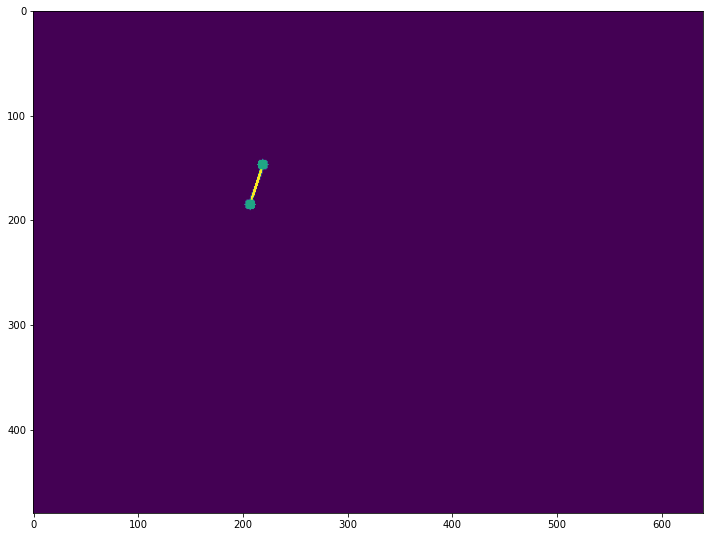

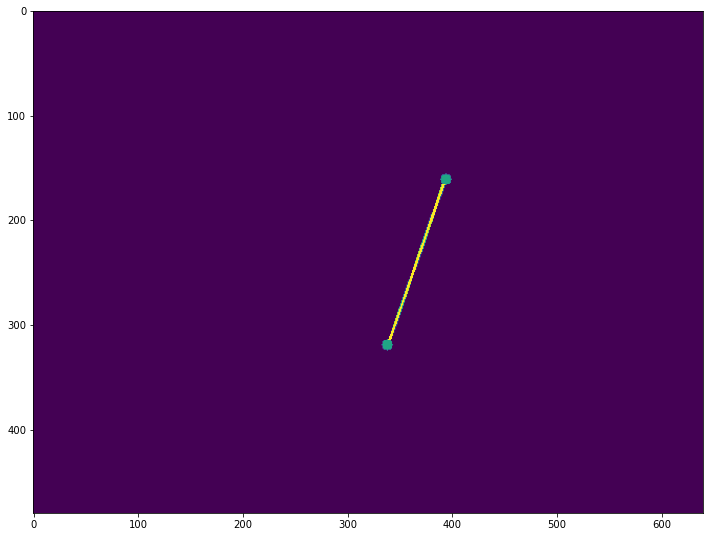

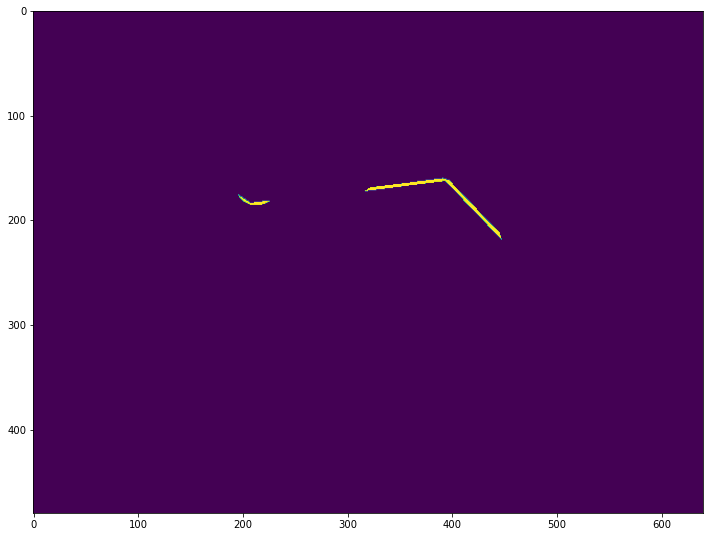

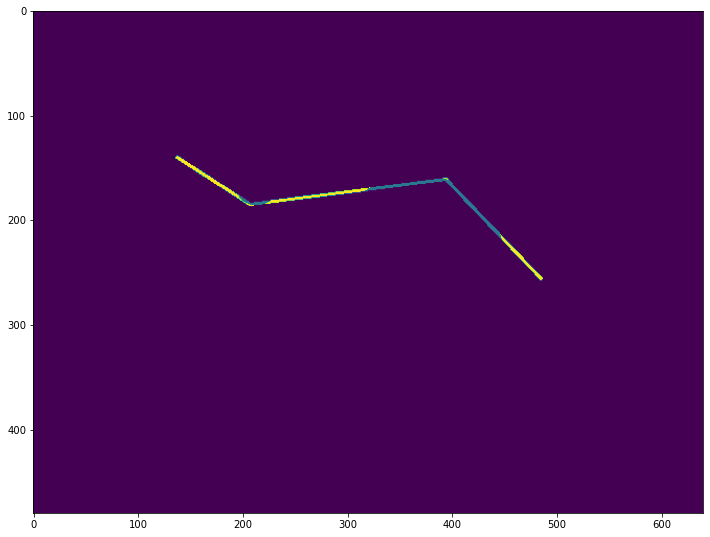

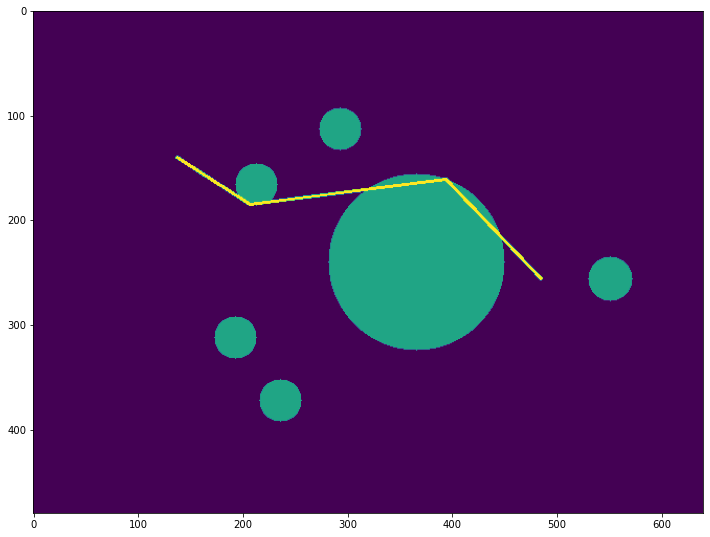

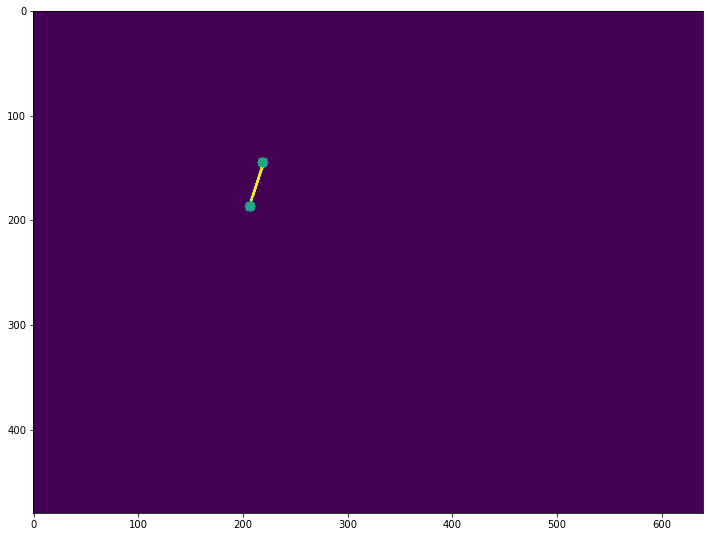

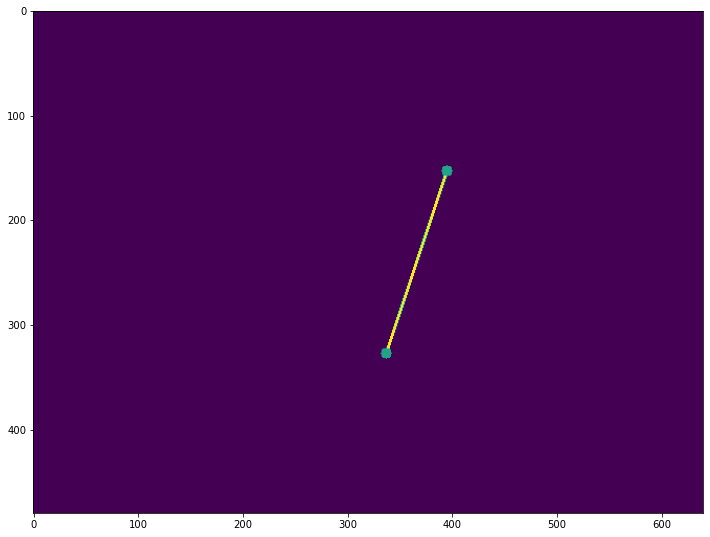

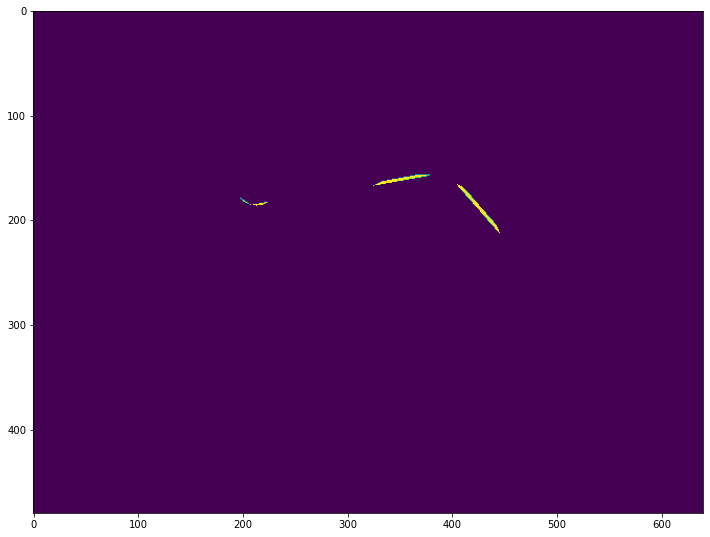

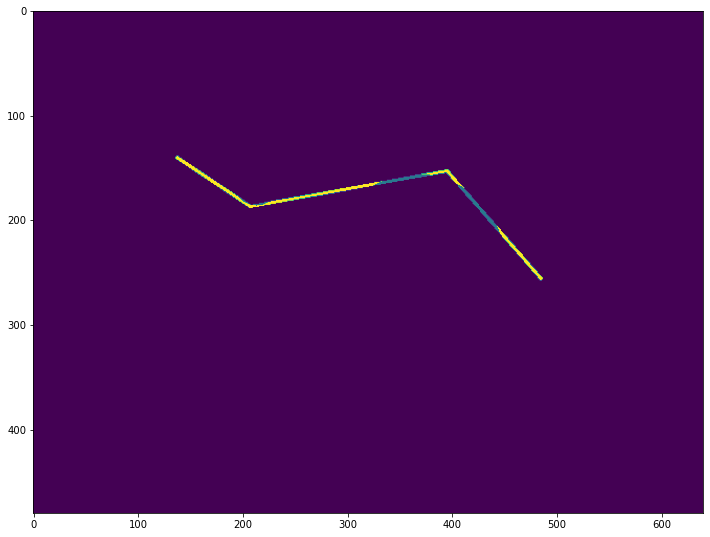

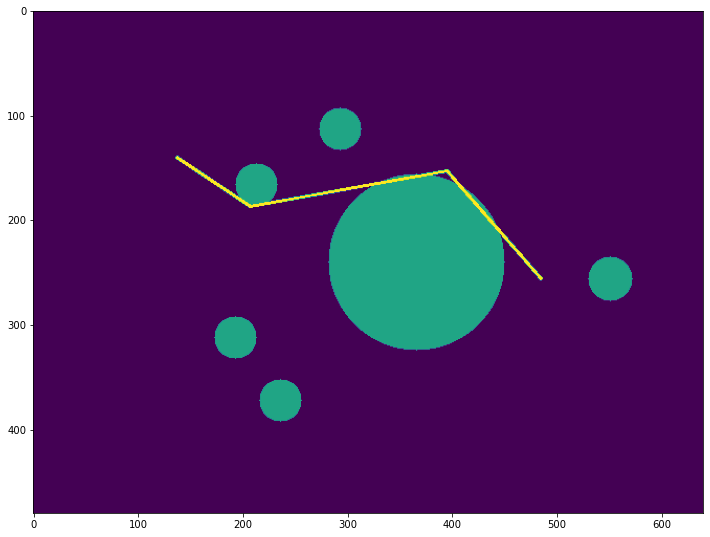

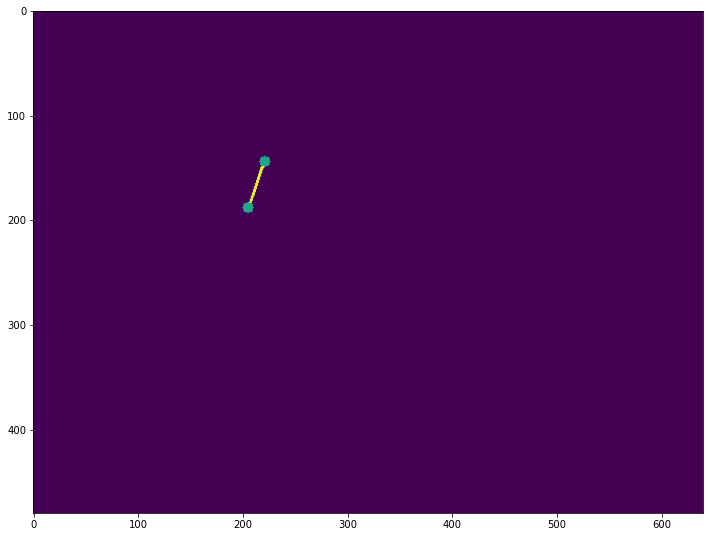

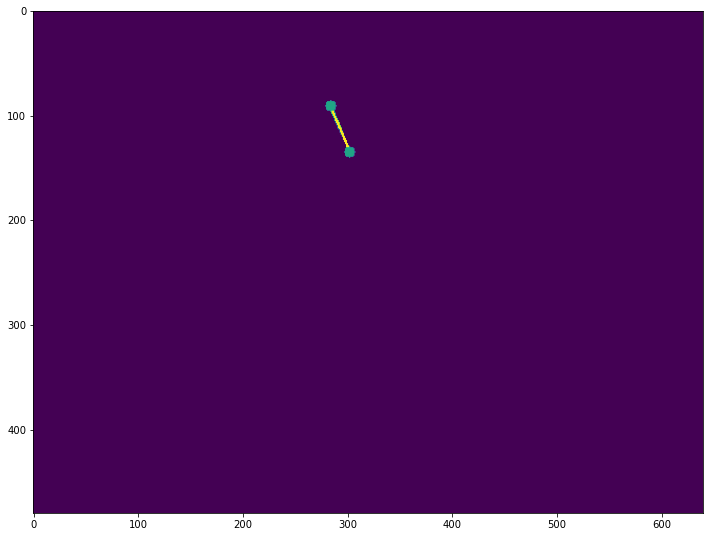

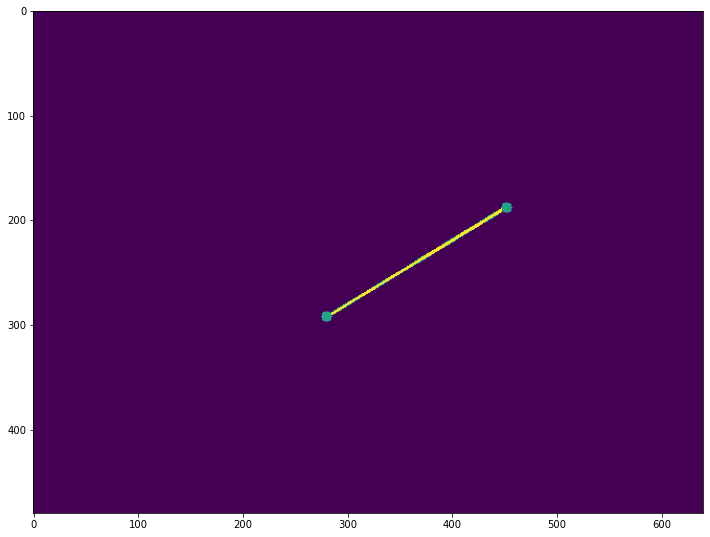

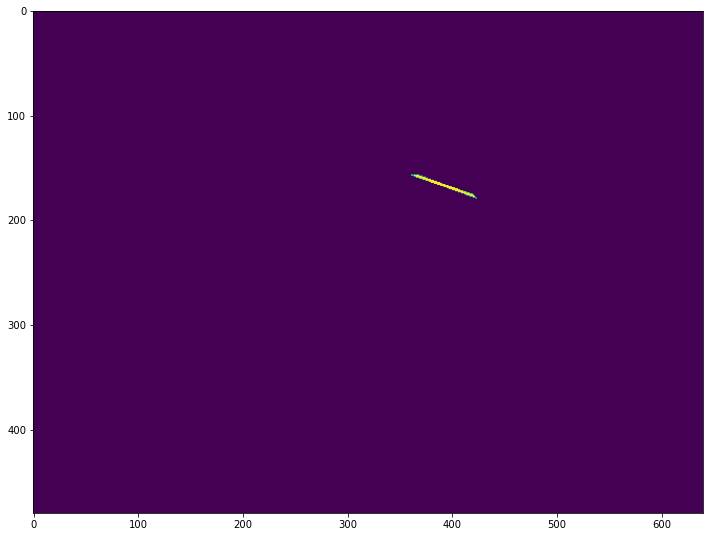

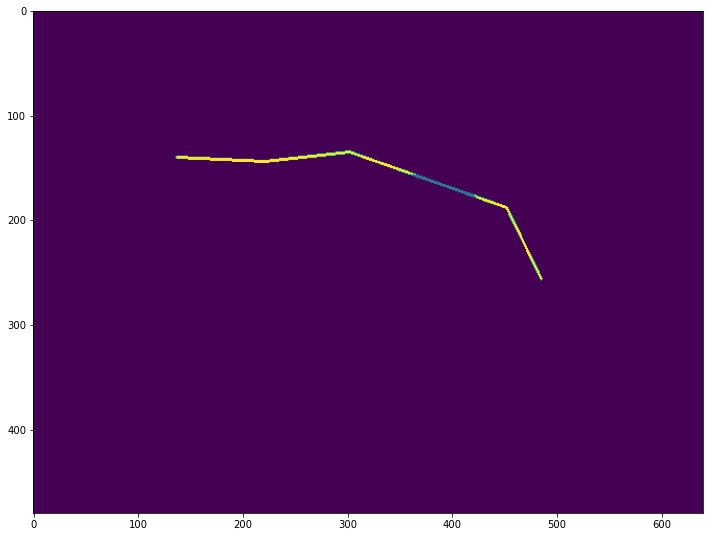

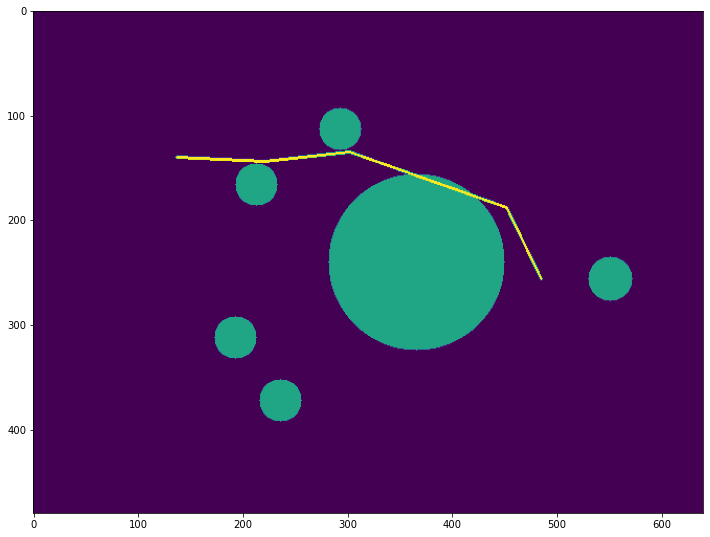

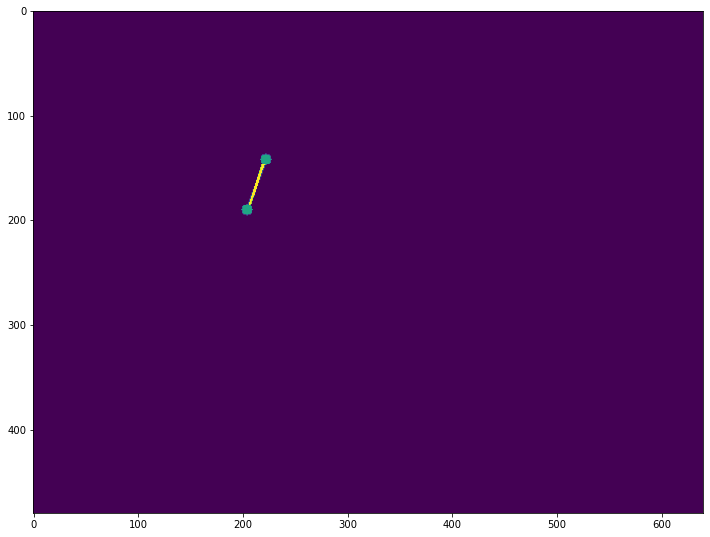

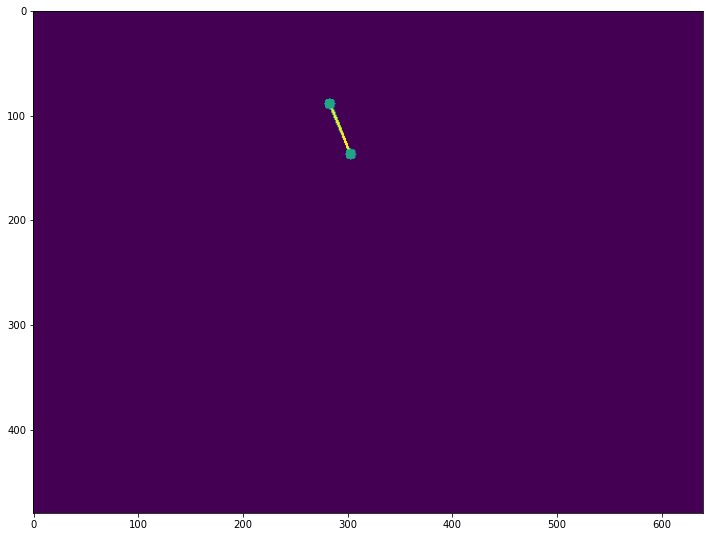

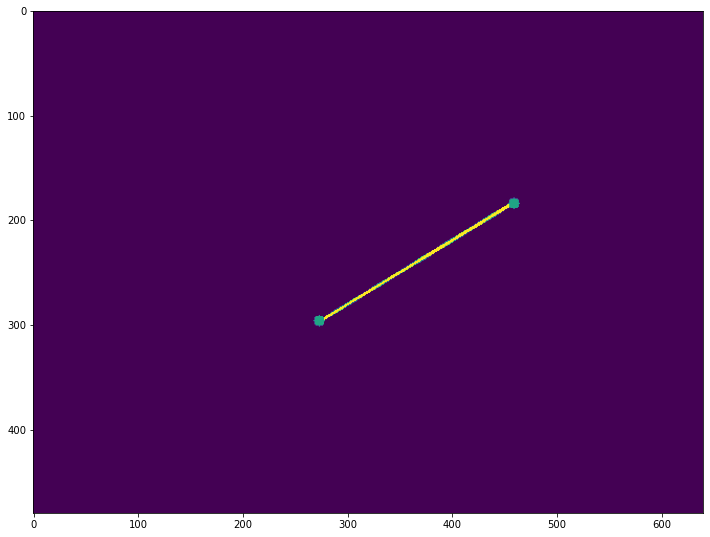

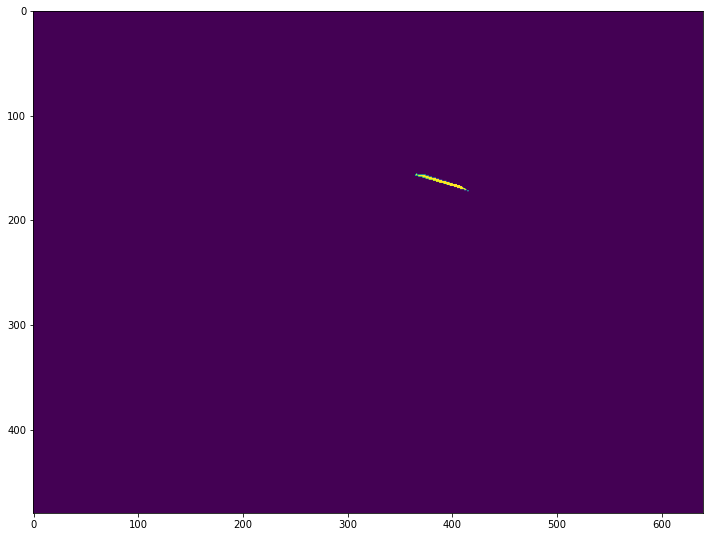

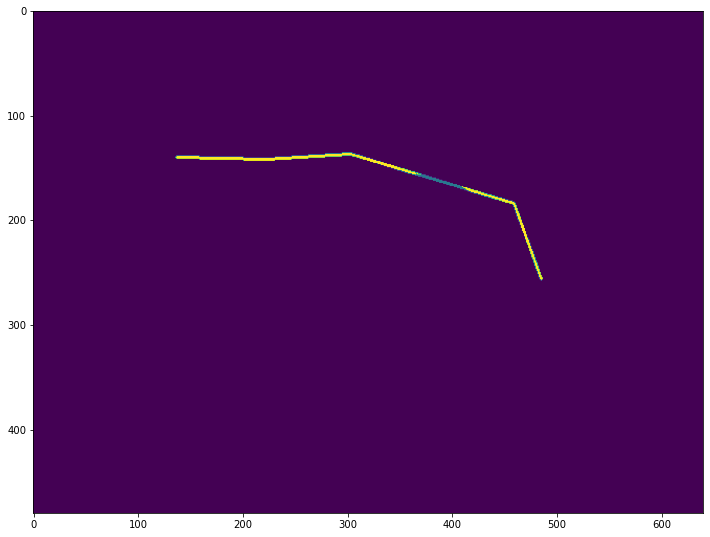

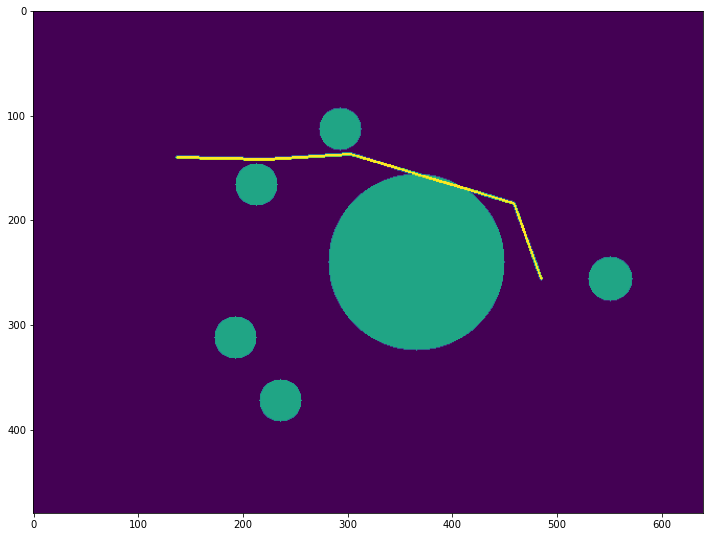

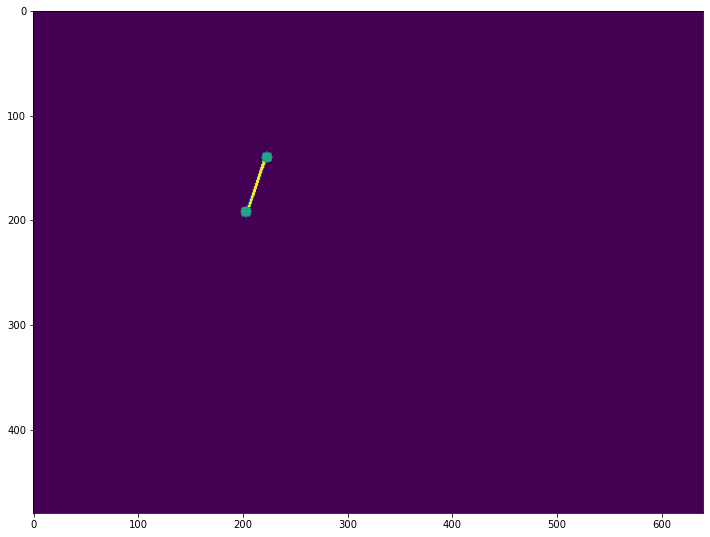

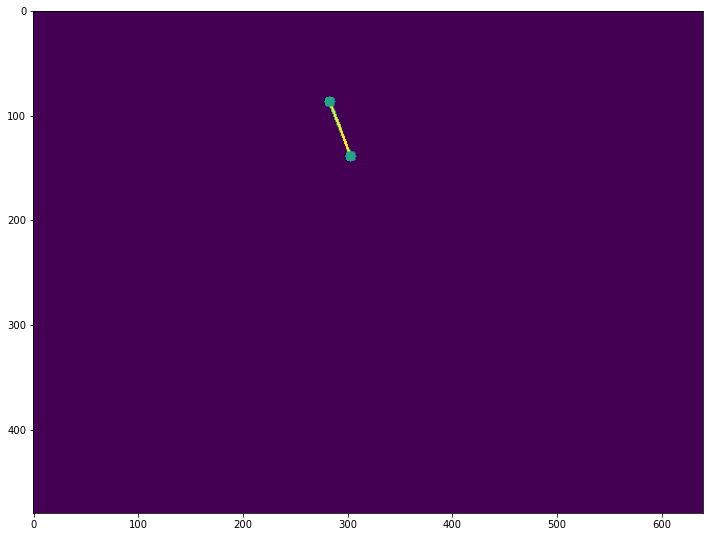

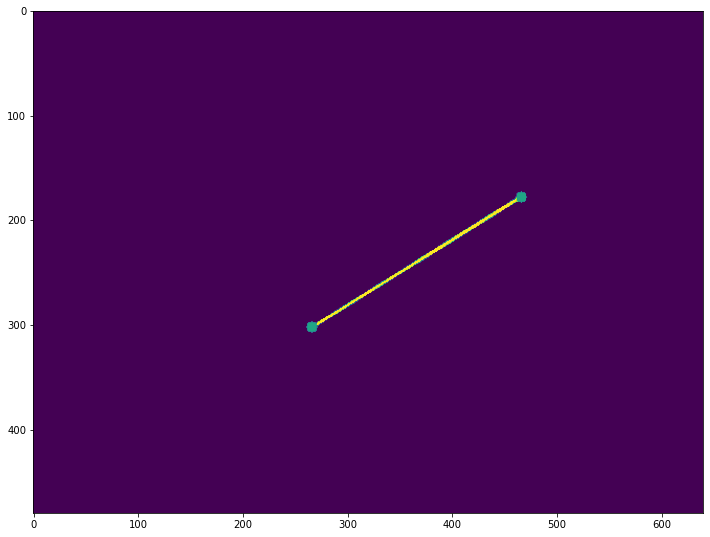

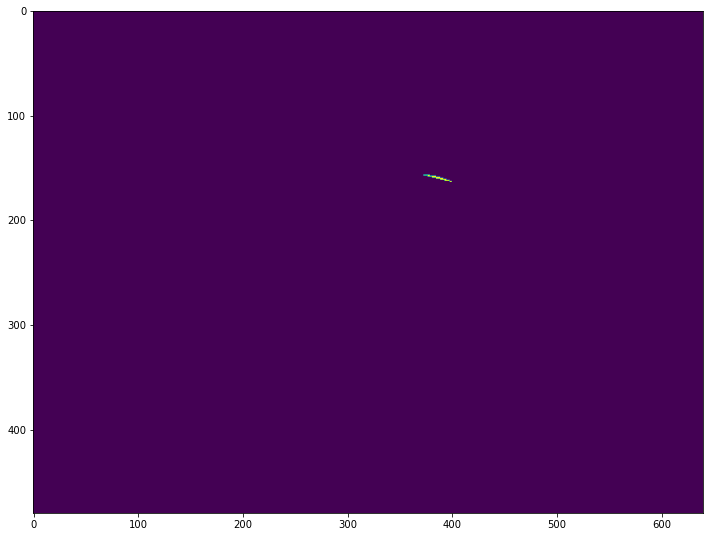

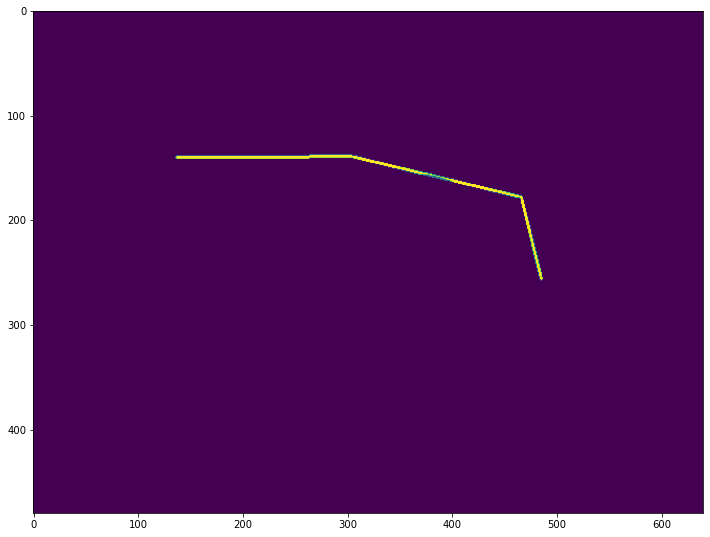

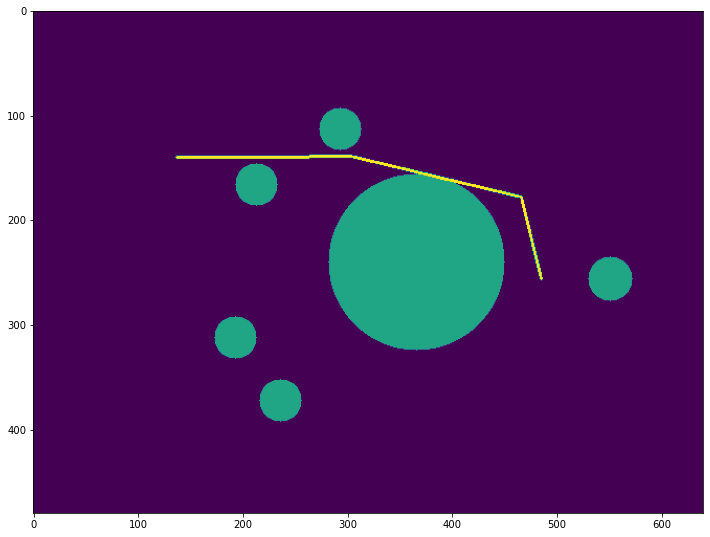

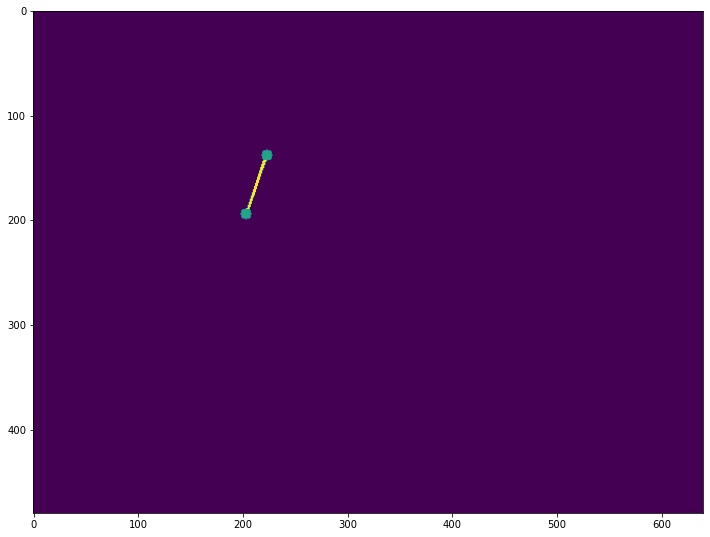

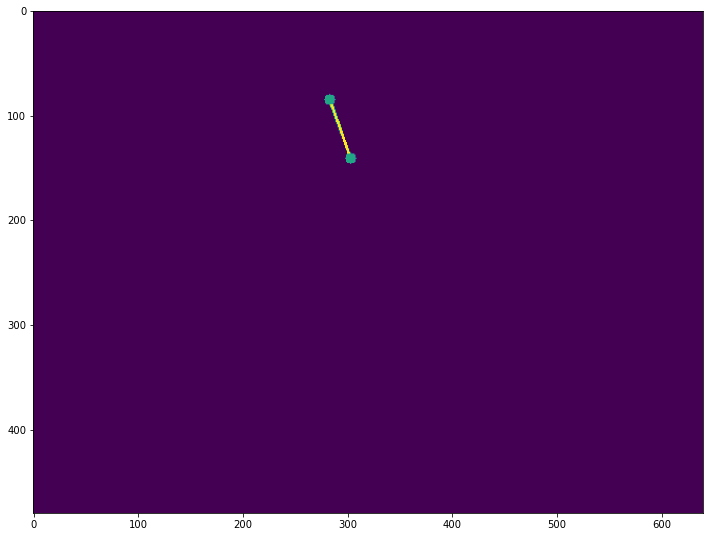

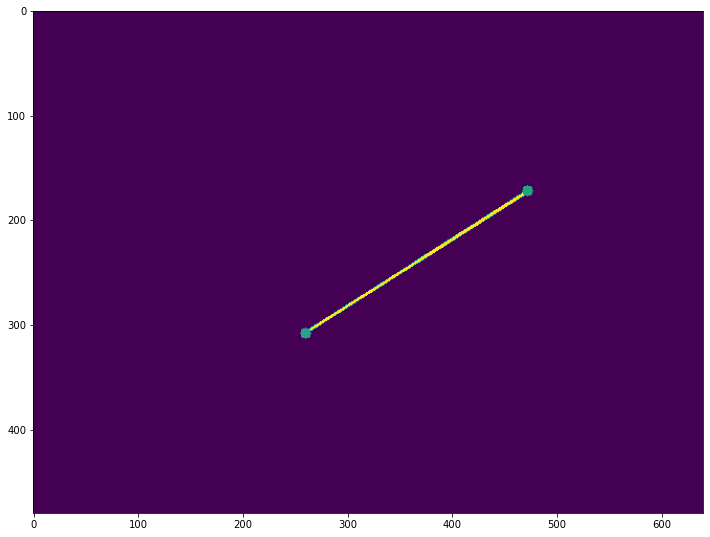

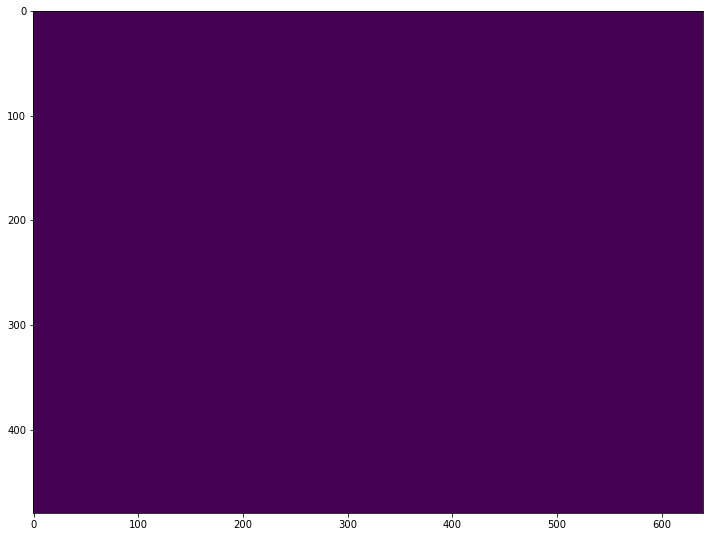

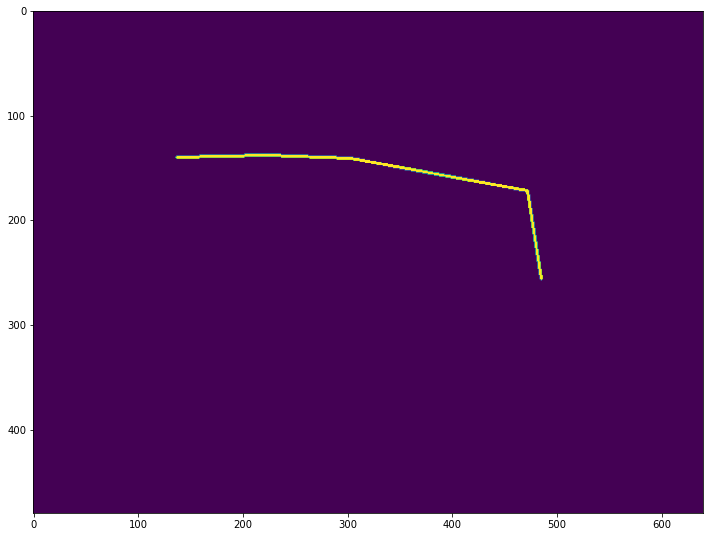

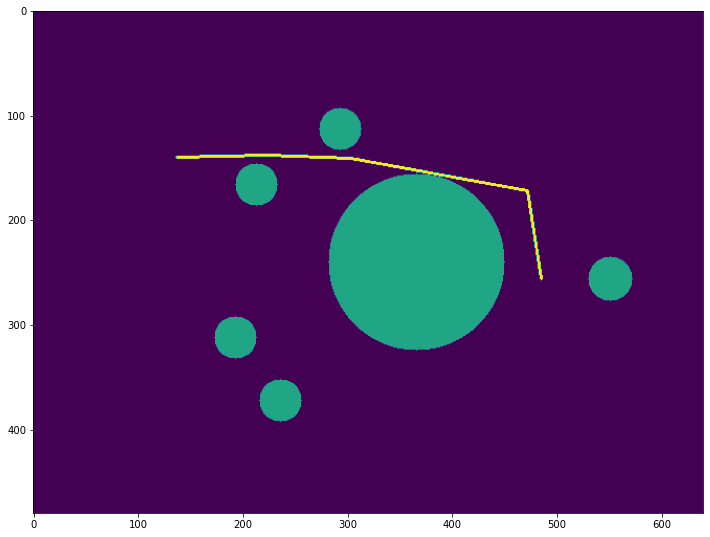

In [54]:
pathing=path.generate()

In [48]:
print(pathing)

[[137 140]
 [207 185]
 [394 161]
 [485 256]]


In [12]:
def dibujarObs(mask,x,y,radio):
    #mask=np.zeros((mask.shape[0],mask.shape[1]),dtype=np.uint8)
    #Dibujando un círculos
    radio=round(radio)
    cv.circle(mask,(x,y),radio,(150),-1)
    return mask
#     plt.figure(figsize=(12,12))
#     plt.imshow(mask, cmap='viridis')

[366 240  84]
[293 113  20]
[213 166  20]
[193 312  20]
[236 372  20]
[551 256  21]


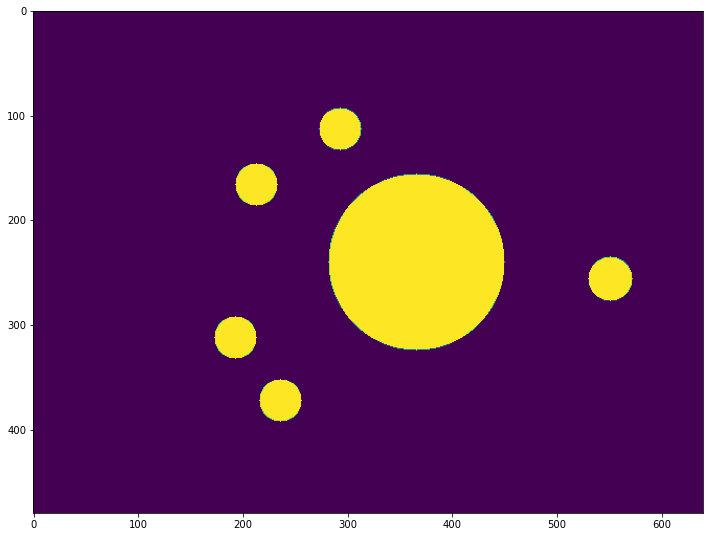

In [13]:
mask = np.zeros((480,640),dtype=np.uint8)
for i in obstaculos:
    mask = dibujarObs(mask,i[0],i[1],i[2])
    print(i)
    
plt.figure(figsize=(12,12))
plt.imshow(mask, cmap='viridis')

[137 140]
[223 138]
[223 138]
[303 141]
[303 141]
[472 172]
[472 172]
[485 256]
[137 140]
[223 138]
[223 138]
[303 141]
[303 141]
[472 172]
[472 172]
[485 256]


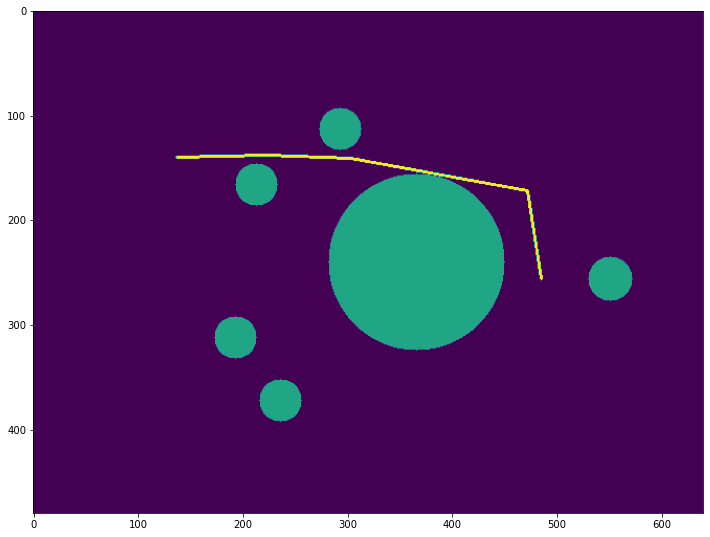

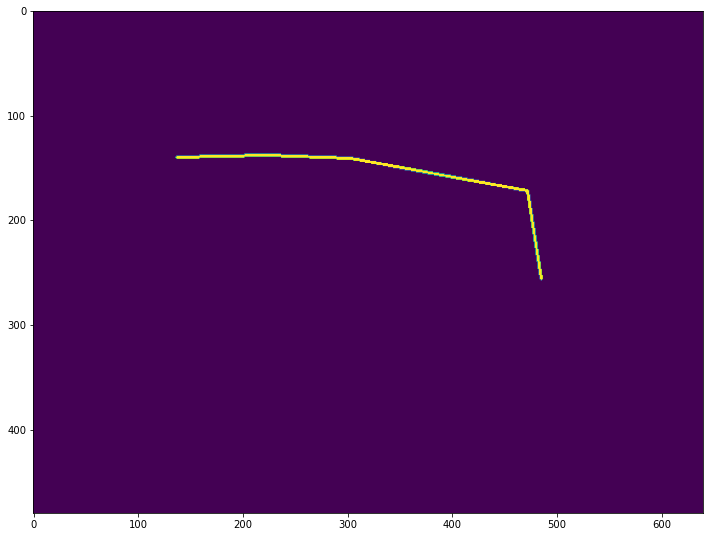

In [17]:
#dibujando path
def dibujandoPath(pathing,mask=np.array([]),tamaño_imagen=(480,640)):
    if mask.all():
        mask=np.zeros(tamaño_imagen,dtype=np.uint8)
    else:
        mask=mask
    
    p=0
    for i in pathing:
        p=p+1
    
        if p==len(pathing):
            break
    
        cv.line(mask,(i[0],i[1]),(pathing[p][0],pathing[p][1]),(255),2)
        print(i)
        print(pathing[p])
    plt.figure(figsize=(12,12))
    plt.imshow(mask, cmap='viridis')
    return mask
maskN=dibujandoPath(pathing,mask)
mask1=dibujandoPath(pathing)

In [15]:
def seg_color(src,bajos, altos):
        mask = cv.inRange(src, bajos, altos)
        return mask
def maskIntersecciones(mask1, mask):
        if mask1.size == 0:
            return np.array([])
        
        diferencias=cv.subtract(mask1,mask)
#         plt.figure(figsize=(12,12))
#         plt.imshow(diferencias,cmap="viridis")
        inters = np.array([105], dtype=np.uint8)
        #print(np.unique(diferencias))
        mask = seg_color(diferencias, inters, inters)
        return mask

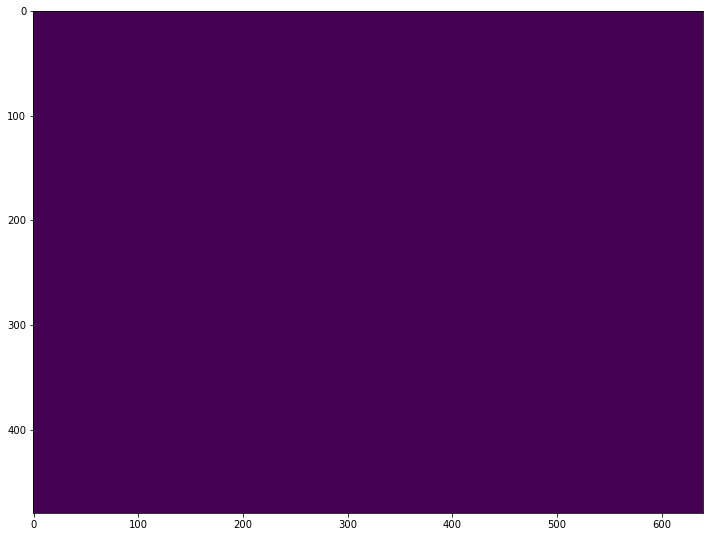

In [16]:
mask2=maskIntersecciones(mask1,mask)
plt.figure(figsize=(12,12))
plt.imshow(mask2,cmap="viridis")

In [157]:
mask2.any()
mask3=np.zeros((640,480),dtype=np.uint8)
print(mask2.any())
print(mask3.any())

True
False


In [9]:
#terminar algoritmo con riesgos controlados
#validacion, escenarios diversos sencillos, complejos, imposibles y buscar soluciones
##mas iteraciones,conclusiones de algoritmo y buscar planes b
#depurar

In [53]:
class juan:
    def __init__(self,path):
        self.path= path
        self.p=self.path
        
    def ola(self):
        self.path=self.p
        
        self.qhac()
        return self.path
    def qhac(self):
        self.path=1
    

In [54]:
j= juan(0)

In [55]:
print(j.ola())

0
